Shape: (153207, 784)


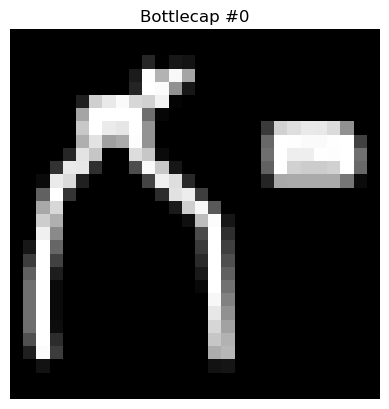

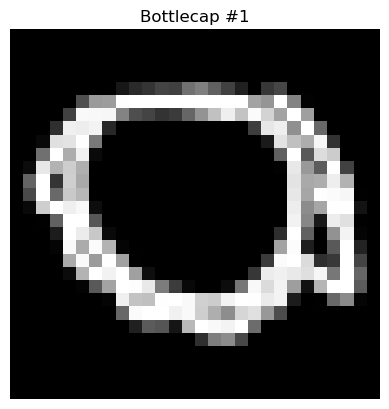

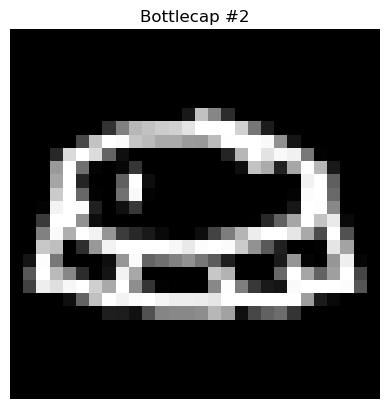

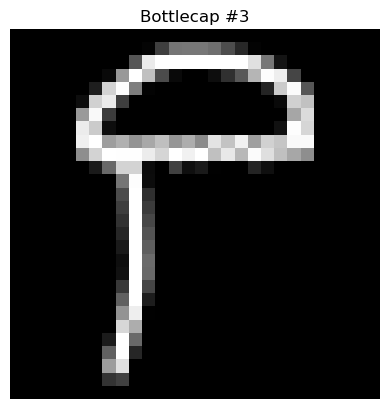

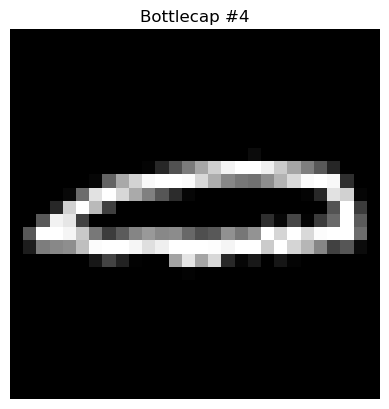

In [1]:
import numpy as np
import matplotlib
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 加载 .npy 文件
bottlecap = np.load("full_numpy_bitmap_bottlecap.npy")

print("Shape:", bottlecap.shape)  # 应该是 (N, 784)，N = 图像数量

# 显示前5张图像
for i in range(5):
    image = bottlecap[i].reshape(28, 28)  # 784 -> 28x28
    plt.imshow(image, cmap='gray')
    plt.title(f"Bottlecap #{i}")
    plt.axis('off')
    plt.show()

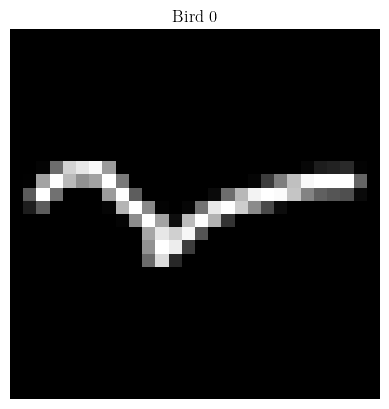

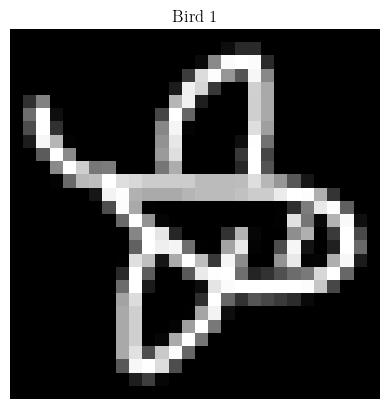

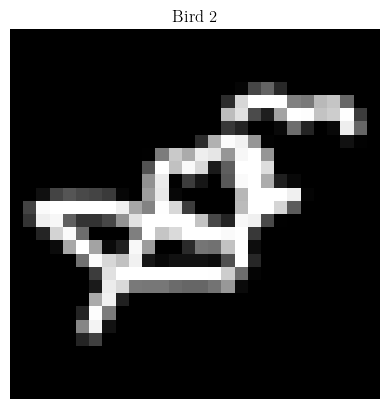

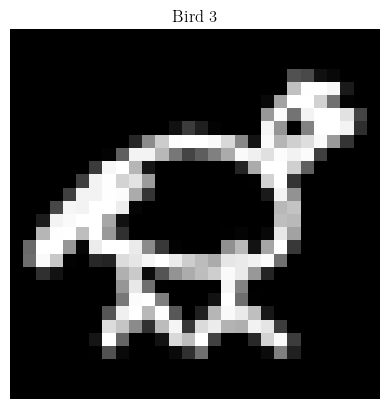

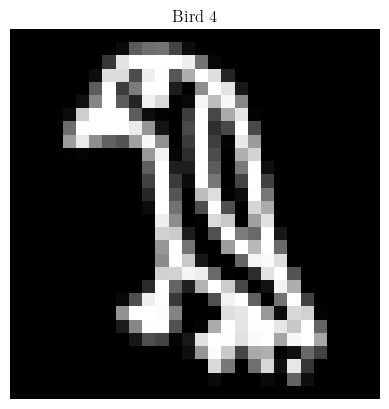

In [123]:
bird = np.load("full_numpy_bitmap_bird.npy")
for i in range(5):
    image = bird[i].reshape(28, 28)  # 784 -> 28x28
    plt.imshow(image, cmap='gray')
    plt.title(f"Bird {i}")
    plt.axis('off')
    plt.show()

In [11]:
bird.shape

(133572, 784)

In [13]:
bottlecap.shape

(153207, 784)

In [78]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


N = 10000
X = np.concatenate([bottlecap[:N], bird[:N]])#各取10000
y = np.array([0]*N + [1]*N)#分类label

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

X = X.astype(np.float32) / 255.0
X = X.reshape(-1, 1, 28, 28)#



class QuickDrawDataset(Dataset):
    def __init__(self, X, y):
        #转换成tensor
        self.X = torch.tensor(X)#[10000, 1, 28, 28]
        self.y = torch.tensor(y)#[10000]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#训练集训练模型
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = QuickDrawDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
##打乱顺序并不打乱标签和图像对应结构，为了防止某一个batch全是一类，防止模型容易产生偏见

#1/3测试集做点云
X_ph, _, y_ph, _ = train_test_split(X_test, y_test, test_size=1/3, random_state=42)
test_dataset = QuickDrawDataset(X_ph, y_ph)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)#保持顺序一致

'''fig, axes = plt.subplots(1, 2)
for i, label in enumerate([0, 1]):
    idx = np.where(y == label)[0][0]
    axes[i].imshow(X[idx][0], cmap='gray')
    axes[i].set_title("Bottlecap" if label == 0 else "Bird")
    axes[i].axis('off')
plt.tight_layout()
plt.show()'''

'''for images, labels in dataloader:
    print(images, labels)'''

'for images, labels in dataloader:\n    print(images, labels)'

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np



# 复现论文里出现的mlp模型：10层，每层深度10
class MLP10Layer(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=10, output_dim=2, activation):
        super(MLP10Layer, self).__init__()
        self.activation_type = activation.lower()
        
        # 创建10层，每层10个神经元
        self.layers = nn.ModuleList()#pyTorch中的一个容器（container），用来 存储多个 nn.Module（比如 nn.Linear 层）的列表
        
        self.layers.append(nn.Linear(input_dim, hidden_dim))#输入层到第一个隐藏层，[784, 10]
        #nn.linear为线性变换层wx+b,pytorch会自动更新权重矩阵和偏移量
        
        for _ in range(8):#layer2, ...layer9维度：[10, 10]
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))  # 输出层[10, 2]

    
    def activate(self, x):
        if self.activation_type == 'relu':
            return F.relu(x)
        elif self.activation_type == 'tanh':
            return torch.tanh(x)
        elif self.activation_type == 'leaky_relu':
            return F.leaky_relu(x, negative_slope=0.2)
        else:
            return x

    def forward(self, x, return_all=False):#x本来是[batch_size, 1, 28, 28] 1为通道数，这里是灰度图像只有一个通道
        outputs = [x.view(x.size(0), -1)]  #flatten输入点云ν₀，变为[batch_size, 784]
        
        #中间9个隐藏层，每一层都是线性+activation
        for i in range(9):
            x = self.layers[i](outputs[-1])#上一层输出放到这
            x = self.activate(x)
            outputs.append(x)  

        
        #输出层[batch_size, 2], 
        #第一个数：该样本是类别 0（如：bottlecap）的原始得分, 
        #第二个数：该样本是类别 0（如：bird）的原始得分
        logits = self.layers[9](outputs[-1])
        outputs.append(logits)  

        if return_all:
            return outputs  #返回所有层点云供后续计算persistent homology
        else:
            return logits  #只返回最终输出，供分类







In [ ]:
#训练函数
def train(model, dataloader, num_epochs, lr=0.02):
    model.train()#dropout,batchnorm
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    #每个epoch学习率乘以 gamma=0.999，即每轮都缓慢衰减
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)  # exponential decay

    #自动对logits做softmax分类，然后和labels计算交叉熵损失
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for images, labels in dataloader:#image size: [64, 1, 28, 28]
            #清除上一轮梯度
            optimizer.zero_grad()
            #输出logit
            outputs = model(images)
            #计算当前 batch 的损失
            loss = criterion(outputs, labels)
            #反向传播，自动计算所有参数的梯度
            loss.backward()
            #更新参数：W -= lr * dW
            optimizer.step()
        scheduler.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [92]:

model_mlp = MLP10Layer(activation='leaky_relu')
train(model_mlp, train_dataloader, num_epochs=3000)



Epoch 0, Loss: 0.4415
Epoch 500, Loss: 0.0015
Epoch 1000, Loss: 0.0017
Epoch 1500, Loss: 0.0022
Epoch 2000, Loss: 0.0000
Epoch 2500, Loss: 0.0000


In [62]:
#自定义CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        #卷积层
        #16个卷积核映射16张特征图
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  #图像通道数=1，卷积核数量=16，卷积核3*3
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),#[batch_size, 16,28,28]->[batch_size, 16,14, 14]

            nn.Conv2d(16, 32, kernel_size=3, padding=1), 
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),#[batch_size, 32, 14,14]->[batch_size, 32,7,7]
        )

        #全连接层

        self.fc = nn.Sequential(
            nn.Linear(32 * 7 * 7, 64), #只能是2维：X @ W.T + b，32*7*7映射到下一个空间变64维度（神经元个数）
            nn.LeakyReLU(0.2),
            nn.Linear(64, 2) 
        )

    def forward(self, x, return_all=False):
        #2层卷积前向传播
        out1 = self.conv[0](x)#卷积
        out2 = self.conv[1](out1)#激活
        out3 = self.conv[2](out2)#池化
        out4 = self.conv[3](out3)#卷积
        out5 = self.conv[4](out4)#激活
        out6 = self.conv[5](out5)#池化

        #进入全连接层前，输入必须是 2D 张量[batch,flatten后的维度]
        flat = out6.view(out6.size(0), -1)
        out7 = self.fc[0](flat)#全连接
        out8 = self.fc[1](out7)#激活
        logits = self.fc[2](out8)#softmax分类

        if return_all:
            return [x.view(x.size(0), -1),   
                    out1.view(x.size(0), -1), 
                    out2.view(x.size(0), -1),
                    out3.view(x.size(0), -1), 
                    out4.view(x.size(0), -1),
                    out5.view(x.size(0), -1),
                    out6.view(x.size(0), -1), 
                    out7,
                    out8, 
                    logits]                 
        return logits




Epoch 0, Loss: 0.6254


In [101]:
model_cnn=CNN()
train(model_cnn, train_dataloader, num_epochs=1000)

Epoch 0, Loss: 0.1610
Epoch 500, Loss: 0.0000


In [64]:
for images, labels in train_dataloader:
    outputs = model_cnn(images, return_all=True)
print(outputs)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([[-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755],
        [-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755],
        [-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755],
        ...,
        [-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755],
        [-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755],
        [-0.0875, -0.0875, -0.0875,  ..., -0.0755, -0.0755, -0.0755]],
       grad_fn=<ViewBackward0>), tensor([[-0.0175, -0.0175, -0.0175,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0175, -0.0175, -0.0175,  ..., -0.0151, -0.0151, -0.0151],
        [-0.0175, -0.0175, -0.0175,  ..., -0.0151, -0.0151, -0.0151],
        ...,
        [-0.0175, -0.0175, -0.0175,  ..., -0.0151, -0.

In [86]:


#提取点云进行persistent homology计算
#提取1，5，10层的点云
def extract_pointcloud(model, datalodaer, layers):
    model.eval()
    layer_outputs_dict = {k: [] for k in layers}
    
    with torch.no_grad():
        for images, labels in datalodaer:
            outputs = model(images, return_all=True)  #得到ν₀到ν₁₀
            #取某层
            for k in layer_outputs_dict:
                layer_outputs_dict[k].append(outputs[k].cpu().numpy())
    
    '''layer_outputs_dict[5]:[
        array([[...], [...], ..., [...]] shape=(64, 10),
        array([[...], ..., [...]] shape=(64, 10),
        ...
    ]'''
    
    # 合并batch:[test_loader/batch_size, 64, 10] --> [test_loader, 10]
    for k in layer_outputs_dict:
        layer_outputs_dict[k] = np.concatenate(layer_outputs_dict[k], axis=0)#竖着拼
    return layer_outputs_dict



In [94]:
#mlp
pointcloud_dict_mlp=extract_pointcloud(model_mlp, test_loader, layers=[1, 5, 10])
pointcloud_dict_mlp

{1: array([[-24.621565  ,  -6.202353  , -14.156417  , ..., -11.2749195 ,
          -8.16701   , -14.698275  ],
        [ -3.6254635 ,   0.19720459,  -9.215556  , ...,  -5.754539  ,
          -3.4397132 , -25.018568  ],
        [ -5.46034   ,  29.07278   ,  -7.619756  , ..., -12.481273  ,
         -10.793186  , -14.810242  ],
        ...,
        [-15.766704  ,  -0.6162556 ,  69.44546   , ...,  -9.262088  ,
         -10.790857  ,  -6.226918  ],
        [-35.46208   ,  -2.874024  ,   9.994945  , ..., -18.327787  ,
          -9.183254  , -13.536395  ],
        [-16.26322   ,  -3.3468063 ,  -2.025791  , ...,  -8.9021635 ,
         -11.169864  ,  -9.718811  ]], dtype=float32),
 5: array([[ 123.18339   ,  -14.719569  ,  283.54242   , ...,   -5.9391108 ,
          -16.44777   ,   17.201324  ],
        [ -74.10372   ,   94.90638   , -204.65565   , ...,   26.906693  ,
          271.20404   ,   -0.53780794],
        [  96.75895   ,  -11.82223   ,  220.98418   , ...,   -5.37409   ,
          -13.

In [105]:
pointcloud_dict_cnn=extract_pointcloud(model_cnn, test_loader, layers=[1, 6, 9])
pointcloud_dict_cnn

{1: array([[-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836],
        [-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836],
        [-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836],
        ...,
        [-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836],
        [-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836],
        [-0.572972 , -0.572972 , -0.572972 , ..., -1.2430836, -1.2430836,
         -1.2430836]], dtype=float32),
 6: array([[-0.41638717, -0.41638184, -0.41638336, ..., -5.7054443 ,
         -5.705446  , -5.705446  ],
        [-0.37872925, -0.37872544, -0.37872657, ..., -5.7054443 ,
         -5.705446  , -5.7054477 ],
        [-0.37872583, -0.37872657, -0.37872657, ..., -5.7054443 ,
         -5.7054453 , -5.705446  ],
        ...,
        [-0.37872848, -0.3787262 , -0.3787262 , ..., -5.705445  ,
   

In [15]:
import gudhi as gd
import gudhi.representations
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import networkx as nx



#实际只有第一维784需要降维
def pca_reduce(point_cloud, dim):
    if point_cloud.shape[1] > dim:
        pca = PCA(n_components=dim)
        pca50_point_cloud = pca.fit_transform(point_cloud)
        return pca50_point_cloud
    else:
        return point_cloud


#复现论文里图测地距离（δₖ）：根据 k-NN 图，两个点之间的最短路径边数，而不是欧几里得距离
def compute_graph_geodesic_distance(points, k=10):
    """
    构建knn图并计算所有点对（点云）之间的geodesic distance
    输出一个对称的[n, n]距离矩阵
    """
    nbrs = NearestNeighbors(n_neighbors=k).fit(points)
    knn_graph = nbrs.kneighbors_graph(points, mode='connectivity')
    G = nx.from_scipy_sparse_array(knn_graph)

    # 所有节点对最短路径长度，单位边权为1
    lengths = dict(nx.all_pairs_shortest_path_length(G))

    n = len(points)
    dist_matrix = np.full((n, n), np.inf)
    for i in lengths:
        for j in lengths[i]:
            dist_matrix[i, j] = lengths[i][j]
    return dist_matrix



#构建Vietoris–Rips复形并计算 persistent homology
def compute_persistent_homology(dist_matrix, max_dim=2, epsilon=2.5):
    """
    输入：δₖ距离矩阵
    返回：persistence barcode（dim=0,1,...,max_dim）
    """
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=epsilon)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    diag = simplex_tree.persistence(homology_coeff_field=2)
    return diag


def betti_numbers(diagram):
    """
    统计每一维的 Betti 数：β₀, β₁, β₂
    """
    counts = Counter()
    for dim, (birth, death) in diagram:
        if death > birth:  # 排除 trivial bar
            counts[dim] += 1
    return counts.get(0, 0), counts.get(1, 0), counts.get(2, 0)

In [17]:
#dim=0:连通分量
#dim=1：洞，环
#dim=2：空腔（球面）


def visualize(pointcloud_dict, y_ph, model_name, layers):
    fig = plt.figure(figsize=(5 * 3, 12))
    
    for i, layer in enumerate(layers):
        pca50_point_cloud = pca_reduce(pointcloud_dict[layer], dim=50)
        dist_matrix = compute_graph_geodesic_distance(pca50_point_cloud, k=10)
        diag = compute_persistent_homology(dist_matrix, max_dim=2, epsilon=2.5)#(dim, (birth, death))
        #print(diag)
        ##(dim, (birth, death)),表示这个拓扑特征从参数 ε 增长过程中哪个时刻“出生”和“死亡”
        
    
        # 可视化
        name = f"Layer {layer}"
        
         # Barcode
        ax1 = fig.add_subplot(3, 3, i + 1)
        gd.plot_persistence_barcode(diag, axes=ax1)
        ax1.set_title(f"{name} Barcode", fontsize=12)
    
    
        #persistent diagram
        ax2 = fig.add_subplot(3, 3, i + 4)
        gd.plot_persistence_diagram(diag, axes=ax2)
        ax1.set_title(f"{name} diagram", fontsize=12)
    
        
    
        #3d scatter-plot(二分类可视化)
        if pointcloud_dict[layer].shape[1]==2:
            point_cloud_3 = np.hstack([pca50_point_cloud, np.zeros((pca50_point_cloud.shape[0], 1))])
        else:
            point_cloud_3 = pca_reduce(pointcloud_dict[layer], dim=3)#
        print(point_cloud_3.shape)

        ax3 = fig.add_subplot(3, 3, i + 7, projection='3d')
        
        #y_ph是个长度为n的0-1矩阵
        #point_cloud_3[y_ph == 0]取出所有类别为 0 的点
        #point_cloud_3[y_ph == 0, 0/1/2]分别取出第0，1，2维
        ax3.scatter(point_cloud_3[y_ph == 0, 0], point_cloud_3[y_ph == 0, 1], point_cloud_3[y_ph == 0, 2],
                    c='red', label='Class 0', s=5, alpha=0.6)
        ax3.scatter(point_cloud_3[y_ph == 1, 0], point_cloud_3[y_ph == 1, 1], point_cloud_3[y_ph == 1, 2],
                    c='blue', label='Class 1', s=5, alpha=0.6)
        ax3.set_title(f"{name} Scatter", fontsize=12)
        ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_zticks([])
        ax3.legend(loc='upper right')


    
    
    plt.tight_layout()
    plt.show()
    return betti_layer_dict




#出生时刻：在某个ε值下第一次出现的时候
#死亡时刻：
#随着 ε 从 0 逐渐增大，点与点之间会先连边（连通块），再闭合成圈（环），最后围出空间（空腔）

In [129]:
def betti(pointcloud_dict, y_ph, model_name, layers):
    betti_layer_dict = {}
    for i, layer in enumerate(layers):
        pca50_point_cloud = pca_reduce(pointcloud_dict[layer], dim=50)
        dist_matrix = compute_graph_geodesic_distance(pca50_point_cloud, k=10)
        diag = compute_persistent_homology(dist_matrix, max_dim=2, epsilon=2.5)
        
        #betti_number
        beta0, beta1, beta2 = betti_numbers(diag)
        complexity = beta0 + beta1 + beta2
        betti_layer_dict[layer] = {"β0": beta0, "β1": beta1, "β2": beta2, "complexity": complexity}
    return betti_layer_dict

betti_mlp=betti(pointcloud_dict_mlp, y_ph, model_name="MLP", layers=[1, 5, 10])
betti_cnn=betti(pointcloud_dict_cnn, y_ph, model_name="MLP", layers=[1, 6, 9])
print(betti_mlp, betti_cnn)
        
    

{1: {'β0': 2666, 'β1': 999, 'β2': 0, 'complexity': 3665}, 5: {'β0': 2666, 'β1': 181, 'β2': 0, 'complexity': 2847}, 10: {'β0': 2666, 'β1': 56, 'β2': 0, 'complexity': 2722}} {1: {'β0': 2666, 'β1': 3475, 'β2': 0, 'complexity': 6141}, 6: {'β0': 2666, 'β1': 3023, 'β2': 0, 'complexity': 5689}, 9: {'β0': 2666, 'β1': 99, 'β2': 0, 'complexity': 2765}}


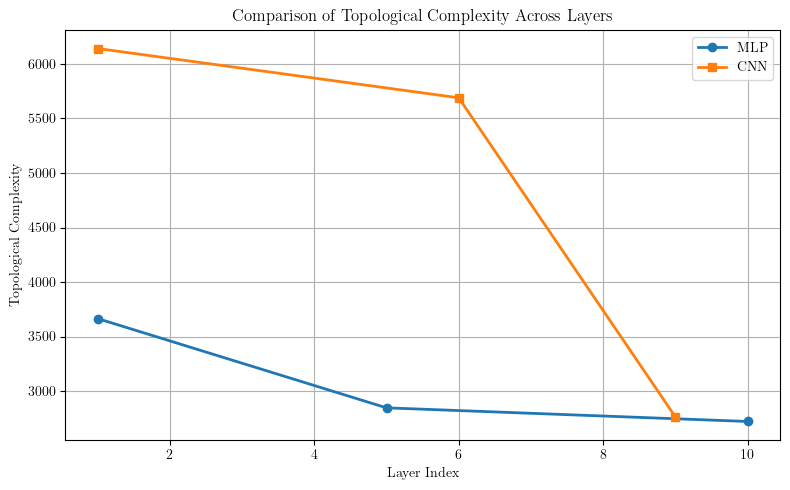

In [139]:
complexities_mlp = [betti_mlp[layer]["complexity"] for layer in [1, 5, 10]]
complexities_cnn = [betti_cnn[layer]["complexity"] for layer in [1, 6, 9]]

plt.figure(figsize=(8, 5))
plt.plot([1, 5, 10], complexities_mlp, marker='o', label='MLP', linewidth=2)
plt.plot([1, 6, 9], complexities_cnn, marker='s', label='CNN', linewidth=2)

plt.xlabel('Layer Index')
plt.ylabel('Topological Complexity')
plt.title('Comparison of Topological Complexity Across Layers')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#CNN第一层复杂度高:CNN的第1层是多个局部卷积核+非线性激活，保留了非常细粒度的局部差异,MLP 的第一层是一个全连接层，具有较强的压缩能力，直接从784 → 10，已经削弱了很多原始拓扑结构
#CNN的复杂度下降更快:表示 CNN 在这类任务上 结构感知更强、更早实现语义压缩

(2666, 3)
(2666, 3)
(2666, 3)


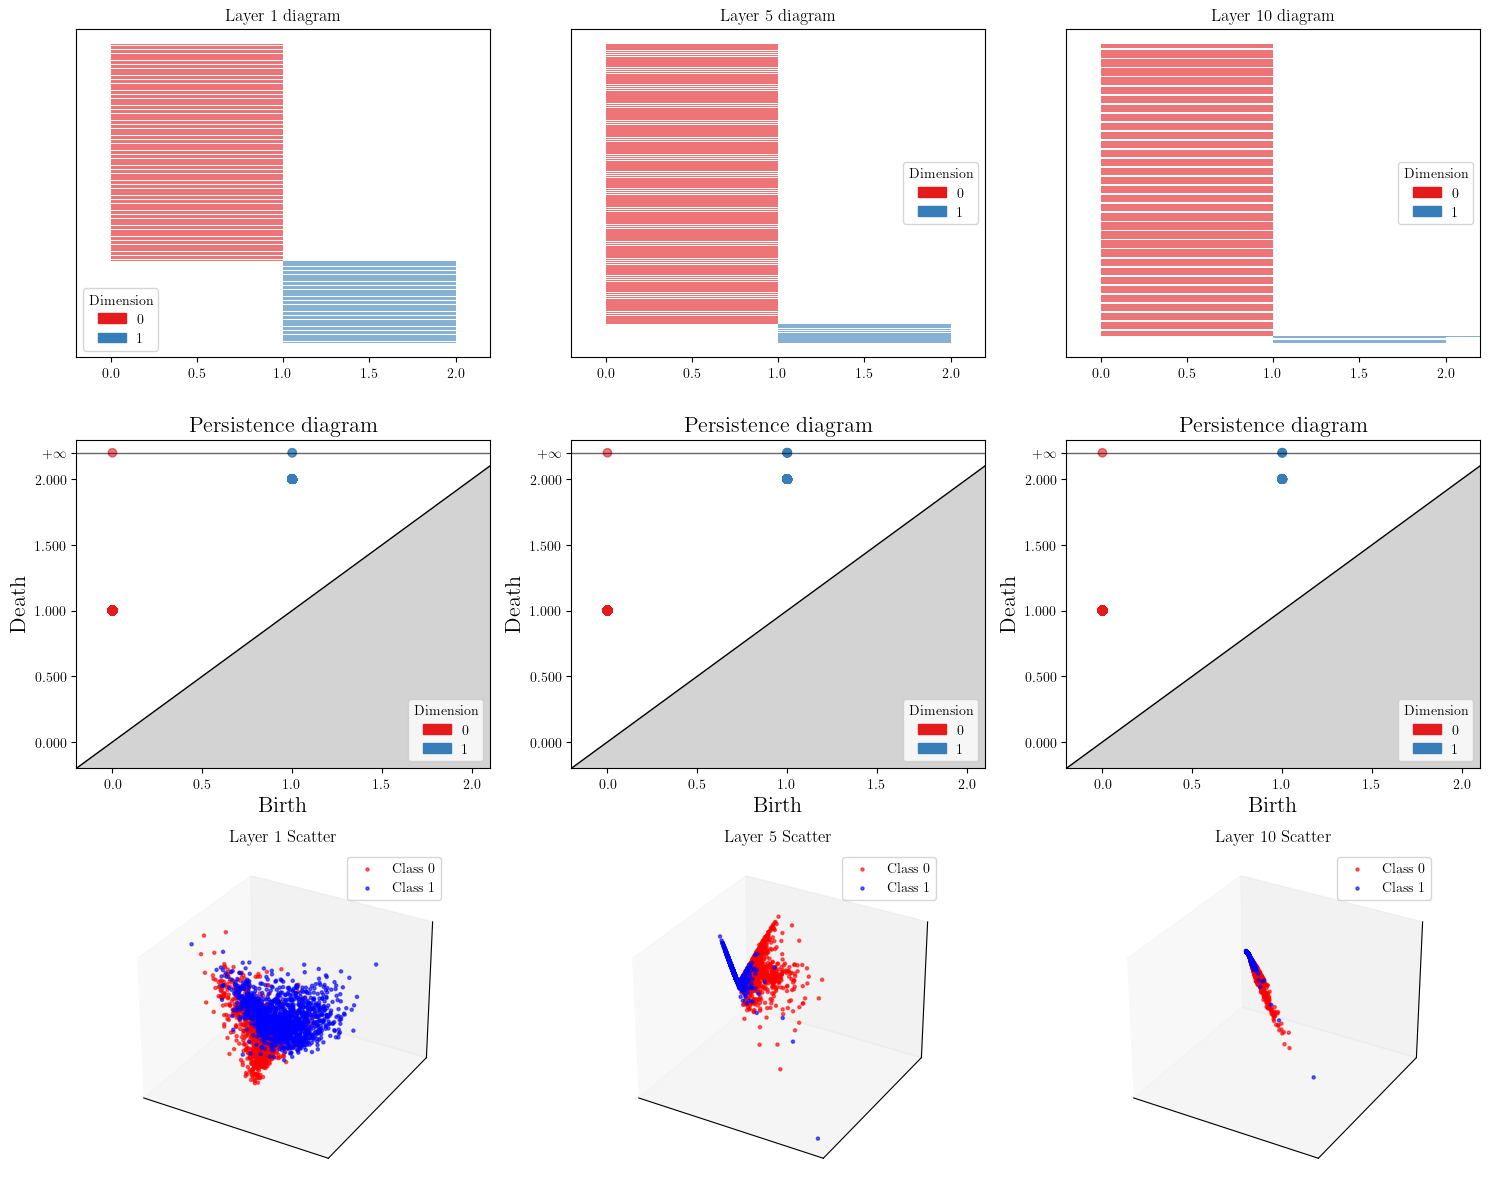

{1: {'β0': 2666, 'β1': 999, 'β2': 0, 'complexity': 3665},
 5: {'β0': 2666, 'β1': 181, 'β2': 0, 'complexity': 2847},
 10: {'β0': 2666, 'β1': 56, 'β2': 0, 'complexity': 2722}}

In [96]:
vis_mlp = visualize(pointcloud_dict_mlp, y_ph, model_name="MLP", layers=[1, 5, 10])
vis_mlp

(2666, 3)
(2666, 3)
(2666, 3)


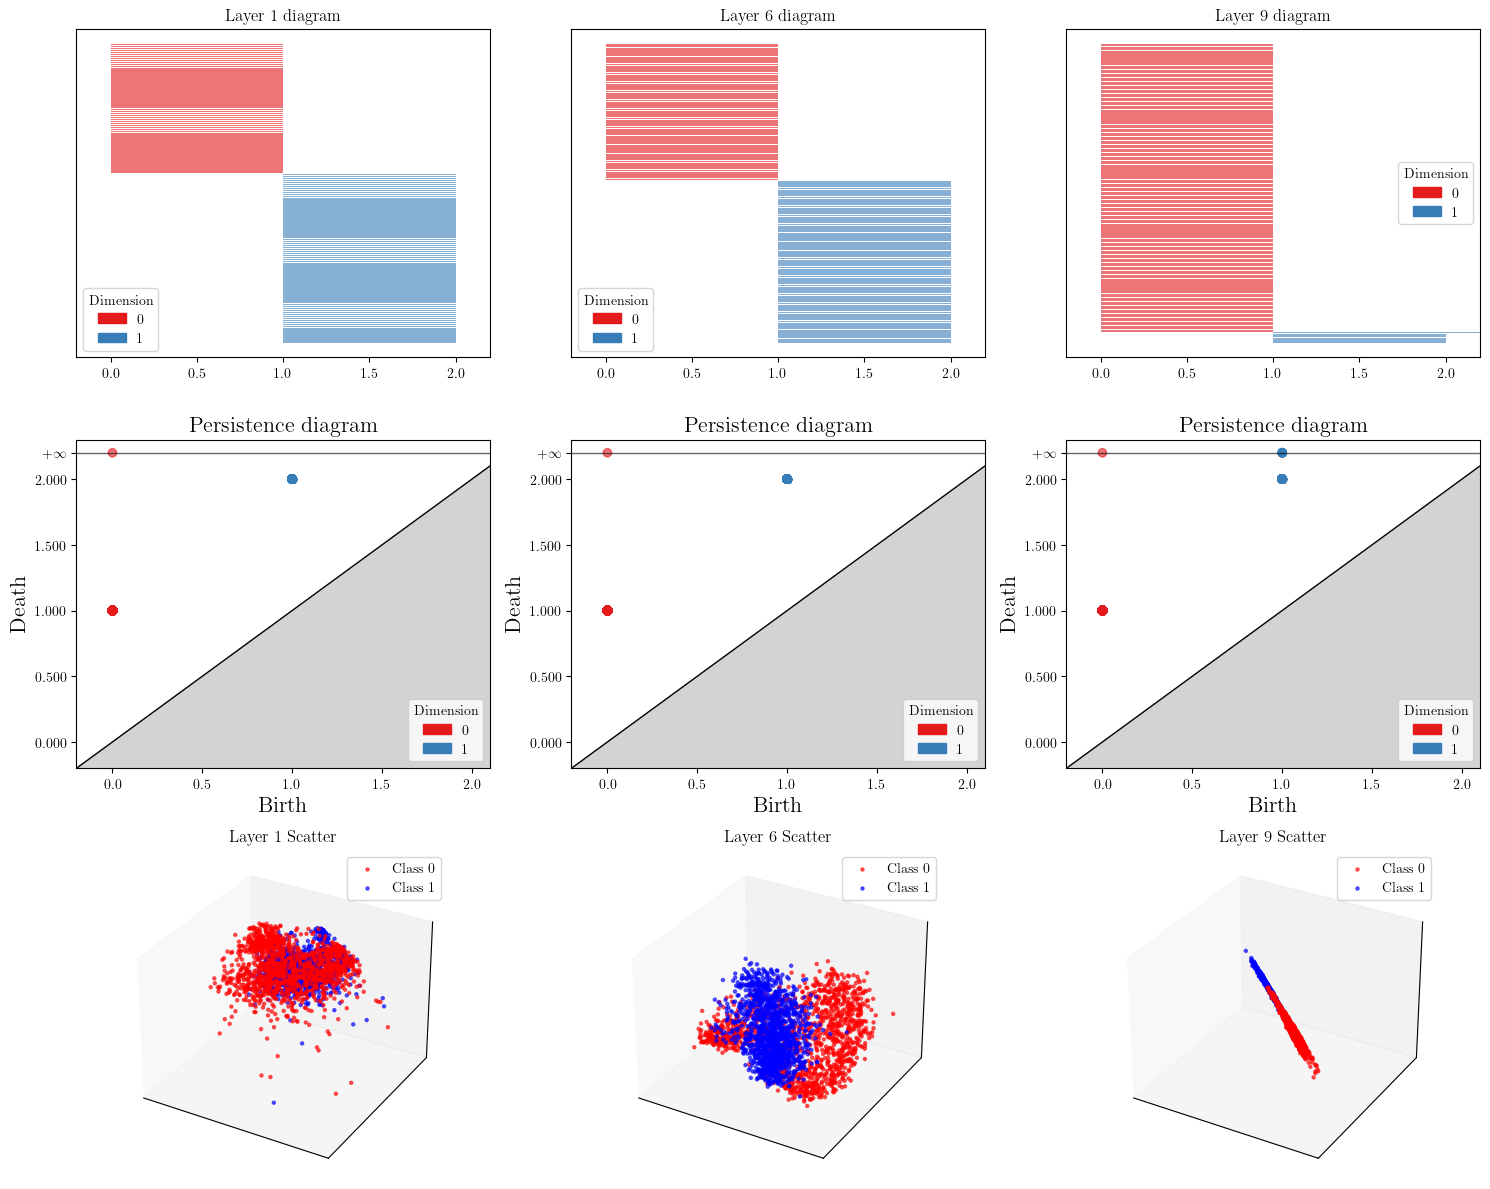

{1: {'β0': 2666, 'β1': 3461, 'β2': 0, 'complexity': 6127},
 6: {'β0': 2666, 'β1': 3143, 'β2': 0, 'complexity': 5809},
 9: {'β0': 2666, 'β1': 99, 'β2': 0, 'complexity': 2765}}

In [107]:
vis_cnn = visualize(pointcloud_dict_cnn, y_ph, model_name="CNN", layers=[1, 6, 9])
vis_cnn

In [113]:
#SVM量化最后一层的激活空间中class separability
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

X_mlp = pointcloud_dict_mlp[10]
X_cnn = pointcloud_dict_cnn[9]

#分类mlp
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp, y_ph, test_size=0.3, random_state=42)

clf = SVC(kernel='linear')  # 或 kernel='rbf'
clf.fit(X_train_mlp, y_train_mlp)
y_pred_mlp = clf.predict(X_test_mlp)
print("Accuracy for mlp:", accuracy_score(y_test_mlp, y_pred_mlp))
print("F1-score for mlp:", f1_score(y_test_mlp, y_pred_mlp))



Accuracy for mlp: 0.8775
F1-score for mlp: 0.8740359897172236


In [115]:
#分类cnn
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_ph, test_size=0.3, random_state=42)


clf.fit(X_train_cnn, y_train_cnn)
y_pred_cnn = clf.predict(X_test_cnn)


print("Accuracy for cnn:", accuracy_score(y_test_cnn, y_pred_cnn))
print("F1-score for cnn:", f1_score(y_test_cnn, y_pred_cnn))

Accuracy for cnn: 0.94875
F1-score for cnn: 0.9440654843110505
